In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [12]:
# Define directories
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Image dimensions
img_width, img_height = 100, 100
batch_size = 32
epochs = 20

# Data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Data preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='binary',
    shuffle=False  # Do not shuffle validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='binary',
    shuffle=False  # Important for evaluation metrics
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
# Define LeNet-5 model architecture
def build_lenet5(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, (1, 1), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (2, 2), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # Adding dropout layer
        Dense(256, activation='relu'),
        Dropout(0.5),  # Adding dropout layer
        Dense(64, activation='relu'),
        Dropout(0.5),  # Adding dropout layer
        Dense(1, activation='sigmoid')
    ])
    return model

# Build the model
input_shape = (img_width, img_height, 1)  # Grayscale images have 1 channel
model = build_lenet5(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('last.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
]

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      64        
                                                                 
 batch_normalization_3 (Bat  (None, 100, 100, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 49, 49, 64)        8256      
                                                                 
 batch_normalization_4 (Bat  (None, 49, 49, 64)        256       
 chNormalization)                                                
                                                      

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
163/163 [==============================] - 115s 690ms/step - loss: 0.4558 - accuracy: 0.8533 - val_loss: 2.6084 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 127s 777ms/step - loss: 0.2221 - accuracy: 0.9283 - val_loss: 3.9223 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 114s 698ms/step - loss: 0.1672 - accuracy: 0.9411 - val_loss: 1.5835 - val_accuracy: 0.6474
Epoch 4/20
163/163 [==============================] - 111s 679ms/step - loss: 0.1254 - accuracy: 0.9517 - val_loss: 0.9192 - val_accuracy: 0.7420
Epoch 5/20
163/163 [==============================] - 111s 683ms/step - loss: 0.1094 - accuracy: 0.9617 - val_loss: 1.1711 - val_accuracy: 0.7628
Epoch 6/20
163/163 [==============================] - 110s 671ms/step - loss: 0.1073 - accuracy: 0.9595 - val_loss: 0.8739 - val_accuracy: 0.7949
Epoch 7/20
163/163 [==============================] - 108s 662ms/step - loss: 0.0782 - accuracy: 0.9699 - val_loss: 1.0526 -

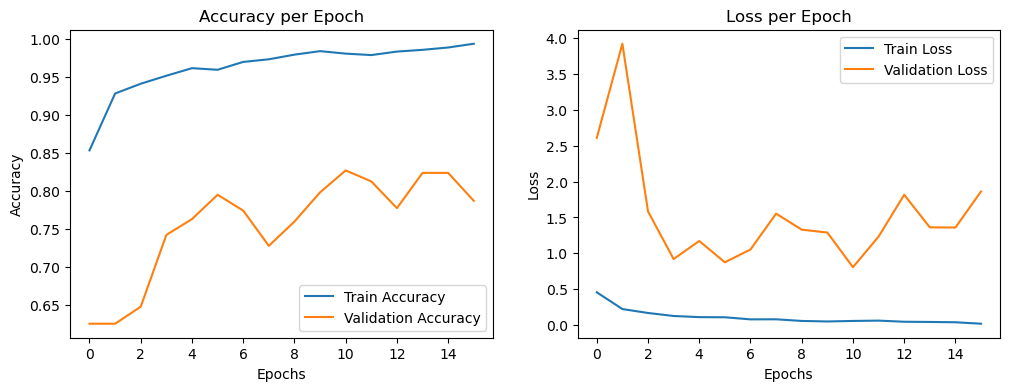

In [17]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 431ms/step


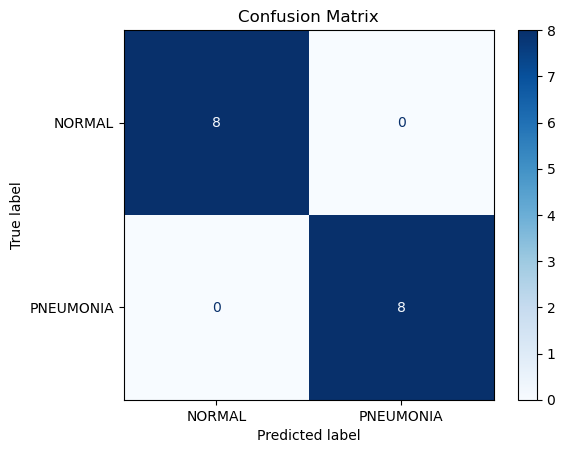

Classification Report
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [16]:
# Load the best model
best_model = load_model('last.keras')

# Predict on the validation set
predictions = best_model.predict(validation_generator)
predictions = (predictions > 0.5).astype(int).reshape(-1)

# Get true labels
true_labels = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))

